In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from src.osrm import run_osrm_in_chunks


# Data ingestion


Eliminamos las columnas que no son de utilidad, las eliminadas son las siguientes:
- vendor_name
- Rate_code
- store_and_forward
- mta_tax
- payment_type
- Tolls_Amt
- surcharge
- Tip_Amt

Como el objetivo es predecir la tarifa pre-travel, quitamos:
- Trip_Dropoff_DateTime
- Trip_Distance



In [2]:
cols_to_use = ['Trip_Pickup_DateTime','Passenger_Count', 'Start_Lon',
               'Start_Lat', 'End_Lon', 'End_Lat','Fare_Amt', 'Total_Amt']


In [3]:
# Leer archivo parquet
df1 = pd.read_parquet("../data/original/yellow_tripdata_2009-01.parquet", columns=cols_to_use)

In [4]:
#df2 = pd.read_parquet("../data/original/yellow_tripdata_2009-02.parquet", columns=cols_to_use)

In [5]:
def fix_column_type(df):
    df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])
    return df



In [6]:
df1 = fix_column_type(df1)

In [7]:
df1

,Trip_Pickup_DateTime,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt
0,2009-01-04 02:52:00,1,-73.991957,40.721567,-73.993803,40.695922,8.9,9.40
1,2009-01-04 03:31:00,3,-73.982102,40.736290,-73.955850,40.768030,12.1,14.60
2,2009-01-03 15:43:00,5,-74.002587,40.739748,-73.869983,40.770225,23.7,28.44
3,2009-01-01 20:52:58,1,-73.974267,40.790955,-73.996558,40.731849,14.9,18.45
4,2009-01-24 16:18:23,1,-74.001580,40.719382,-74.008378,40.720350,3.7,3.70
...,...,...,...,...,...,...,...,...
14092408,2009-01-27 14:36:00,5,-73.982013,40.743330,-73.994328,40.750130,6.5,6.50
14092409,2009-01-27 13:56:00,1,-73.972788,40.761988,-73.951477,40.778217,8.1,10.00
14092410,2009-01-23 08:39:44,1,-73.977467,40.751861,-74.009913,40.713470,14.5,14.50
14092411,2009-01-24 23:05:00,3,-73.981295,40.753000,-73.949453,40.779520,10.9,11.40


# Feature Engineering

In [8]:
df1.columns

Index(['Trip_Pickup_DateTime', 'Passenger_Count', 'Start_Lon', 'Start_Lat',
       'End_Lon', 'End_Lat', 'Fare_Amt', 'Total_Amt'],
      dtype='object')

In [9]:
def time_features(df):
    
    # Extraer hora y día de la semana
    hour = df['Trip_Pickup_DateTime'].dt.hour
    weekday = df['Trip_Pickup_DateTime'].dt.weekday  # 0=Monday, 6=Sunday
    
    # Codificación cíclica
    df['pickup_hour_sin'] = np.sin(2 * np.pi * hour/24)
    df['pickup_hour_cos'] = np.cos(2 * np.pi * hour/24)
    df['pickup_weekday_sin'] = np.sin(2 * np.pi * weekday/7)
    df['pickup_weekday_cos'] = np.cos(2 * np.pi * weekday/7)
    
    return df

def haversine_distance(df):
    # Radio de la Tierra en km
    R = 6371.0
    
    # Convertir a radianes
    lon1 = np.radians(df['Start_Lon'])
    lat1 = np.radians(df['Start_Lat'])
    lon2 = np.radians(df['End_Lon'])
    lat2 = np.radians(df['End_Lat'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    df['haversine_distance_m'] = R * c * 1000
    return df
    


In [10]:
df1 = time_features(df1)

In [11]:
df1 = haversine_distance(df1)

In [12]:
df1

,Trip_Pickup_DateTime,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt,pickup_hour_sin,pickup_hour_cos,pickup_weekday_sin,pickup_weekday_cos,haversine_distance_m
0,2009-01-04 02:52:00,1,-73.991957,40.721567,-73.993803,40.695922,8.9,9.40,0.500000,0.866025,-0.781831,0.623490,2855.835897
1,2009-01-04 03:31:00,3,-73.982102,40.736290,-73.955850,40.768030,12.1,14.60,0.707107,0.707107,-0.781831,0.623490,4164.867307
2,2009-01-03 15:43:00,5,-74.002587,40.739748,-73.869983,40.770225,23.7,28.44,-0.707107,-0.707107,-0.974928,-0.222521,11672.167416
3,2009-01-01 20:52:58,1,-73.974267,40.790955,-73.996558,40.731849,14.9,18.45,-0.866025,0.500000,0.433884,-0.900969,6835.176748
4,2009-01-24 16:18:23,1,-74.001580,40.719382,-74.008378,40.720350,3.7,3.70,-0.866025,-0.500000,-0.974928,-0.222521,582.928793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092408,2009-01-27 14:36:00,5,-73.982013,40.743330,-73.994328,40.750130,6.5,6.50,-0.500000,-0.866025,0.781831,0.623490,1283.742913
14092409,2009-01-27 13:56:00,1,-73.972788,40.761988,-73.951477,40.778217,8.1,10.00,-0.258819,-0.965926,0.781831,0.623490,2545.044336
14092410,2009-01-23 08:39:44,1,-73.977467,40.751861,-74.009913,40.713470,14.5,14.50,0.866025,-0.500000,-0.433884,-0.900969,5069.266708
14092411,2009-01-24 23:05:00,3,-73.981295,40.753000,-73.949453,40.779520,10.9,11.40,-0.258819,0.965926,-0.974928,-0.222521,3985.861506


In [14]:
df_osrm = run_osrm_in_chunks(df1, concurrency=400, chunk_size=400000)


Procesando filas 0 a 400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 400000 en data/osrm/osrm_results.parquet
Procesando filas 400000 a 800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 800000 en data/osrm/osrm_results.parquet
Procesando filas 800000 a 1200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 1200000 en data/osrm/osrm_results.parquet
Procesando filas 1200000 a 1600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 1600000 en data/osrm/osrm_results.parquet
Procesando filas 1600000 a 2000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 2000000 en data/osrm/osrm_results.parquet
Procesando filas 2000000 a 2400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 2400000 en data/osrm/osrm_results.parquet
Procesando filas 2400000 a 2800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 2800000 en data/osrm/osrm_results.parquet
Procesando filas 2800000 a 3200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 3200000 en data/osrm/osrm_results.parquet
Procesando filas 3200000 a 3600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 3600000 en data/osrm/osrm_results.parquet
Procesando filas 3600000 a 4000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 4000000 en data/osrm/osrm_results.parquet
Procesando filas 4000000 a 4400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 4400000 en data/osrm/osrm_results.parquet
Procesando filas 4400000 a 4800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 4800000 en data/osrm/osrm_results.parquet
Procesando filas 4800000 a 5200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 5200000 en data/osrm/osrm_results.parquet
Procesando filas 5200000 a 5600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 5600000 en data/osrm/osrm_results.parquet
Procesando filas 5600000 a 6000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 6000000 en data/osrm/osrm_results.parquet
Procesando filas 6000000 a 6400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 6400000 en data/osrm/osrm_results.parquet
Procesando filas 6400000 a 6800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 6800000 en data/osrm/osrm_results.parquet
Procesando filas 6800000 a 7200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 7200000 en data/osrm/osrm_results.parquet
Procesando filas 7200000 a 7600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 7600000 en data/osrm/osrm_results.parquet
Procesando filas 7600000 a 8000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 8000000 en data/osrm/osrm_results.parquet
Procesando filas 8000000 a 8400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 8400000 en data/osrm/osrm_results.parquet
Procesando filas 8400000 a 8800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 8800000 en data/osrm/osrm_results.parquet
Procesando filas 8800000 a 9200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 9200000 en data/osrm/osrm_results.parquet
Procesando filas 9200000 a 9600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 9600000 en data/osrm/osrm_results.parquet
Procesando filas 9600000 a 10000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 10000000 en data/osrm/osrm_results.parquet
Procesando filas 10000000 a 10400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 10400000 en data/osrm/osrm_results.parquet
Procesando filas 10400000 a 10800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 10800000 en data/osrm/osrm_results.parquet
Procesando filas 10800000 a 11200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 11200000 en data/osrm/osrm_results.parquet
Procesando filas 11200000 a 11600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 11600000 en data/osrm/osrm_results.parquet
Procesando filas 11600000 a 12000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 12000000 en data/osrm/osrm_results.parquet
Procesando filas 12000000 a 12400000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 12400000 en data/osrm/osrm_results.parquet
Procesando filas 12400000 a 12800000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 12800000 en data/osrm/osrm_results.parquet
Procesando filas 12800000 a 13200000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 13200000 en data/osrm/osrm_results.parquet
Procesando filas 13200000 a 13600000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 13600000 en data/osrm/osrm_results.parquet
Procesando filas 13600000 a 14000000...


OSRM async:   0%|          | 0/400000 [00:00<?, ?it/s]

Guardado parcial hasta fila 14000000 en data/osrm/osrm_results.parquet
Procesando filas 14000000 a 14400000...


OSRM async:   0%|          | 0/92413 [00:00<?, ?it/s]

Guardado parcial hasta fila 14400000 en data/osrm/osrm_results.parquet


In [16]:
df_osrm

,Trip_Pickup_DateTime,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt,pickup_hour_sin,pickup_hour_cos,pickup_weekday_sin,pickup_weekday_cos,haversine_distance_m,idx,route_distance_m,route_duration_s
0,2009-01-04 02:52:00,1,-73.991957,40.721567,-73.993803,40.695922,8.9,9.40,0.500000,0.866025,-0.781831,0.623490,2855.835897,0,4058.1,461.3
1,2009-01-04 03:31:00,3,-73.982102,40.736290,-73.955850,40.768030,12.1,14.60,0.707107,0.707107,-0.781831,0.623490,4164.867307,1,5113.6,479.9
2,2009-01-03 15:43:00,5,-74.002587,40.739748,-73.869983,40.770225,23.7,28.44,-0.707107,-0.707107,-0.974928,-0.222521,11672.167416,2,16624.6,1364.3
3,2009-01-01 20:52:58,1,-73.974267,40.790955,-73.996558,40.731849,14.9,18.45,-0.866025,0.500000,0.433884,-0.900969,6835.176748,3,8032.7,921.1
4,2009-01-24 16:18:23,1,-74.001580,40.719382,-74.008378,40.720350,3.7,3.70,-0.866025,-0.500000,-0.974928,-0.222521,582.928793,4,969.1,162.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092408,2009-01-27 14:36:00,5,-73.982013,40.743330,-73.994328,40.750130,6.5,6.50,-0.500000,-0.866025,0.781831,0.623490,1283.742913,92408,1439.0,190.9
14092409,2009-01-27 13:56:00,1,-73.972788,40.761988,-73.951477,40.778217,8.1,10.00,-0.258819,-0.965926,0.781831,0.623490,2545.044336,92409,3373.7,408.3
14092410,2009-01-23 08:39:44,1,-73.977467,40.751861,-74.009913,40.713470,14.5,14.50,0.866025,-0.500000,-0.433884,-0.900969,5069.266708,92410,5755.7,831.2
14092411,2009-01-24 23:05:00,3,-73.981295,40.753000,-73.949453,40.779520,10.9,11.40,-0.258819,0.965926,-0.974928,-0.222521,3985.861506,92411,5577.3,559.9


In [1]:
import pandas as pd
df = pd.read_parquet("../data/processed/train_processed.parquet")

In [5]:
df['haversine_distance_m'].describe()

count    2.563631e+07
mean     1.895881e-16
std      1.000000e+00
min     -1.079842e+00
25%     -6.207270e-01
50%     -3.086124e-01
75%      2.600082e-01
max      3.760482e+01
Name: haversine_distance_m, dtype: float64

In [4]:
df

,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt,Real_time,Real_distance,haversine_distance_m,...,pickup_distance_to_jfk_m,dropoff_distance_to_jfk_m,pickup_distance_to_lga_m,dropoff_distance_to_lga_m,pickup_distance_to_nla_m,dropoff_distance_to_nla_m,pickup_distance_to_chp_m,dropoff_distance_to_chp_m,pickup_distance_to_exp_m,dropoff_distance_to_exp_m
0,0.5,-73.974302,40.793618,-73.969983,40.799567,3.7,4.20,120.0,756.39168,-0.787556,...,0.717699,0.779526,-0.229742,-0.264208,0.502826,0.593165,-0.752115,-0.838242,0.550452,0.633786
1,0.1,-73.978383,40.728917,-74.001838,40.750997,9.7,13.20,840.0,4103.82720,0.140549,...,-0.492927,0.365940,0.147843,0.404546,-0.260770,-0.539706,0.449702,0.386552,-0.210008,-0.631125
2,0.1,-74.008587,40.726047,-73.971852,40.797115,18.9,23.28,1500.0,9495.12960,2.206325,...,0.117520,0.752743,0.803520,-0.246692,-0.853826,0.528978,0.914175,-0.773152,-0.757810,0.564000
3,0.2,-73.990640,40.770670,-73.996707,40.737475,10.1,10.60,780.0,4924.59264,0.363080,...,0.513261,0.039003,0.073113,0.413308,-0.082075,-0.573413,-0.123355,0.545811,-0.100230,-0.630060
4,0.3,-74.000665,40.730675,-74.015242,40.716175,10.1,10.60,900.0,3138.22080,-0.294951,...,0.011061,0.143806,0.580409,1.056331,-0.671183,-1.055390,0.722369,1.147908,-0.645854,-0.752727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764256,0.1,-73.950246,40.780030,-73.971637,40.750755,8.1,9.10,589.0,3701.49120,0.360816,...,-0.002565,-0.232809,-0.844442,-0.248193,0.731522,-0.010744,-0.853014,-0.005563,0.666486,-0.103635
6764257,0.1,-73.975246,40.752534,-73.763969,40.713007,33.5,37.65,1764.0,22369.88160,6.020518,...,-0.140570,-3.589455,-0.192794,0.439954,-0.012485,3.688971,-0.018327,-1.786498,-0.090964,3.803253
6764258,0.1,-73.991298,40.741728,-73.992425,40.747938,6.7,7.70,407.0,1287.47520,-0.809941,...,-0.011859,0.124318,0.256568,0.222938,-0.406925,-0.405119,0.395861,0.313610,-0.464262,-0.499447
6764259,0.1,-73.992259,40.742352,-73.980227,40.751400,7.1,7.10,468.0,1770.27840,-0.526832,...,0.018614,-0.054849,0.271018,-0.068507,-0.419160,-0.157085,0.398006,0.095544,-0.479965,-0.253198


In [ ]:
df["Passenger_Count"] = df["Passenger_Count"].astype("float32")
df["Fare_Amt"] = df["Fare_Amt"].astype("float32")
df["Total_Amt"] = df["Total_Amt"].astype("float32")
df["Real_distance"] = df["Real_distance"].astype("float32")
df["Haversine_distance"] = df["Real_distance"].astype("float32")

In [9]:
df

,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt,Real_time,Real_distance,haversine_distance_m,...,pickup_distance_to_jfk_m,dropoff_distance_to_jfk_m,pickup_distance_to_lga_m,dropoff_distance_to_lga_m,pickup_distance_to_nla_m,dropoff_distance_to_nla_m,pickup_distance_to_chp_m,dropoff_distance_to_chp_m,pickup_distance_to_exp_m,dropoff_distance_to_exp_m
0,0.5,-73.974302,40.793618,-73.969983,40.799567,3.7,4.200000,120.0,756.39168,-0.787556,...,0.717699,0.779526,-0.229742,-0.264208,0.502826,0.593165,-0.752115,-0.838242,0.550452,0.633786
1,0.1,-73.978383,40.728917,-74.001838,40.750997,9.7,13.200000,840.0,4103.82720,0.140549,...,-0.492927,0.365940,0.147843,0.404546,-0.260770,-0.539706,0.449702,0.386552,-0.210008,-0.631125
2,0.1,-74.008587,40.726047,-73.971852,40.797115,18.9,23.280001,1500.0,9495.12960,2.206325,...,0.117520,0.752743,0.803520,-0.246692,-0.853826,0.528978,0.914175,-0.773152,-0.757810,0.564000
3,0.2,-73.990640,40.770670,-73.996707,40.737475,10.1,10.600000,780.0,4924.59264,0.363080,...,0.513261,0.039003,0.073113,0.413308,-0.082075,-0.573413,-0.123355,0.545811,-0.100230,-0.630060
4,0.3,-74.000665,40.730675,-74.015242,40.716175,10.1,10.600000,900.0,3138.22080,-0.294951,...,0.011061,0.143806,0.580409,1.056331,-0.671183,-1.055390,0.722369,1.147908,-0.645854,-0.752727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764256,0.1,-73.950246,40.780030,-73.971637,40.750755,8.1,9.100000,589.0,3701.49120,0.360816,...,-0.002565,-0.232809,-0.844442,-0.248193,0.731522,-0.010744,-0.853014,-0.005563,0.666486,-0.103635
6764257,0.1,-73.975246,40.752534,-73.763969,40.713007,33.5,37.650002,1764.0,22369.88160,6.020518,...,-0.140570,-3.589455,-0.192794,0.439954,-0.012485,3.688971,-0.018327,-1.786498,-0.090964,3.803253
6764258,0.1,-73.991298,40.741728,-73.992425,40.747938,6.7,7.700000,407.0,1287.47520,-0.809941,...,-0.011859,0.124318,0.256568,0.222938,-0.406925,-0.405119,0.395861,0.313610,-0.464262,-0.499447
6764259,0.1,-73.992259,40.742352,-73.980227,40.751400,7.1,7.100000,468.0,1770.27840,-0.526832,...,0.018614,-0.054849,0.271018,-0.068507,-0.419160,-0.157085,0.398006,0.095544,-0.479965,-0.253198


In [10]:
import pandas as pd
df = pd.read_parquet("../data/processed_osrm/train_processed_processed.parquet")

In [16]:
df.columns

Index(['Passenger_Count', 'Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat',
       'Fare_Amt', 'Total_Amt', 'Real_time', 'Real_distance',
       'haversine_distance_m', 'pickup_hour_sin', 'pickup_hour_cos',
       'pickup_weekday_sin', 'pickup_weekday_cos', 'pickup_distance_to_nyc_m',
       'dropoff_distance_to_nyc_m', 'pickup_distance_to_jfk_m',
       'dropoff_distance_to_jfk_m', 'pickup_distance_to_lga_m',
       'dropoff_distance_to_lga_m', 'pickup_distance_to_nla_m',
       'dropoff_distance_to_nla_m', 'pickup_distance_to_chp_m',
       'dropoff_distance_to_chp_m', 'pickup_distance_to_exp_m',
       'dropoff_distance_to_exp_m', 'route_distance_m', 'route_duration_s',
       'average_speed_m_s', 'ratio_haversine_osrm'],
      dtype='object')

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, r2_score
import gc

# Cargar datos
train_path = "../data/processed_osrm/train_processed_osrm.parquet"
val_path = "../data/processed_osrm/val_processed_osrm.parquet"

df_train = pd.read_parquet(train_path)
df_val = pd.read_parquet(val_path)

# Definir target y features
target_col = 'Total_Amt'
drop_cols = ['Fare_Amt', 'Real_time', 'Real_distance', target_col]  # eliminar target de features
feature_cols = [c for c in df_train.columns if c not in drop_cols]

X_train = df_train[feature_cols]
y_train = df_train[target_col]
del df_train

X_val = df_val[feature_cols]
y_val = df_val[target_col]

del df_val

# Convertir a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

del X_train
del y_train
del X_val
del y_val

# Parámetros del modelo
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.09,            # learning_rate
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "device": "cuda",       # 🚀 usar GPU
    "random_state": 42
}

# Entrenamiento
evals = [(dtrain, "train"), (dval, "val")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    verbose_eval=True
)

# Predicciones
y_pred = model.predict(dval)

# Métricas
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

gc.collect()


[0]	train-rmse:5.61371	val-rmse:5.67935
[1]	train-rmse:5.20164	val-rmse:5.26648
[2]	train-rmse:4.83323	val-rmse:4.89753
[3]	train-rmse:4.50409	val-rmse:4.56819
[4]	train-rmse:4.21144	val-rmse:4.27527
[5]	train-rmse:3.95213	val-rmse:4.01610
[6]	train-rmse:3.72265	val-rmse:3.78681
[7]	train-rmse:3.52058	val-rmse:3.58491
[8]	train-rmse:3.34318	val-rmse:3.40805
[9]	train-rmse:3.18777	val-rmse:3.25315
[10]	train-rmse:3.05290	val-rmse:3.11884
[11]	train-rmse:2.93530	val-rmse:3.00188
[12]	train-rmse:2.83265	val-rmse:2.89971
[13]	train-rmse:2.74427	val-rmse:2.81178
[14]	train-rmse:2.66856	val-rmse:2.73645
[15]	train-rmse:2.60290	val-rmse:2.67114
[16]	train-rmse:2.54646	val-rmse:2.61508
[17]	train-rmse:2.49843	val-rmse:2.56733
[18]	train-rmse:2.45730	val-rmse:2.52633
[19]	train-rmse:2.42197	val-rmse:2.49123
[20]	train-rmse:2.39192	val-rmse:2.46122
[21]	train-rmse:2.36614	val-rmse:2.43567
[22]	train-rmse:2.34393	val-rmse:2.41339
[23]	train-rmse:2.32426	val-rmse:2.39371
[24]	train-rmse:2.30735	va

NameError: name 'y_val' is not defined

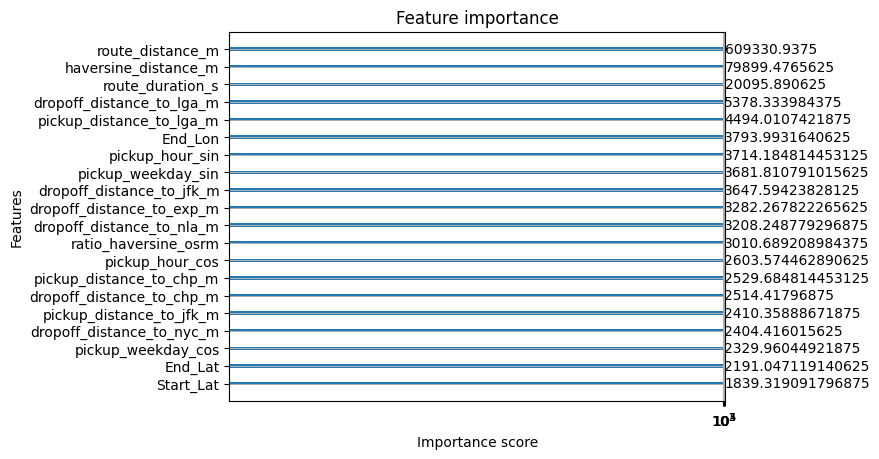

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Graficar importancias
ax = plot_importance(model, importance_type='gain', max_num_features=30)

plt.show()

In [3]:
import pandas as pd
train_path = "../data/processed_osrm/train_processed_processed.parquet"

df_train = pd.read_parquet(train_path)

df_train['Extras'] = df_train['Total_Amt'] - df_train['Fare_Amt']

# Varianza del componente aleatorio
var_extras = df_train['Extras'].var()

In [4]:
import numpy as np

rmse_min = np.sqrt(var_extras)
print(f"RMSE mínimo imposible de superar: {rmse_min:.3f}")

RMSE mínimo imposible de superar: 1.407


In [ ]:
import xgboost as xgb
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    verbose_eval=True
    device = "cuda"
)

In [ ]:
model